# Batch mode

heyoka.py's API supports a mode of operation called *batch mode*.
In batch mode, all the scalar quantities appearing in a system of ODEs
(i.e., state variables, time coordinate, parameters, etc.)
are formally replaced by small vectors of fixed size $n$, so that,
effectively, multiple ODE systems sharing the same mathematical formulation
are being integrated simultaneously using different sets of numerical values.

Because modern CPUs support [SIMD instructions](https://en.wikipedia.org/wiki/SIMD),
the runtime cost of operating on a vector of $n$ scalar values is roughly
equivalent to the cost of operating on a single scalar value, and thus the use of
batch mode can lead to an increase in floating-point throughput up to a factor of $n$.

It is important to emphasise that batch mode does not reduce
the CPU time required to integrate a system of ODEs. Rather, as a fine-grained
form of data parallelism, batch mode allows to integrate multiple ODE systems in parallel
at no additional cost, and it is thus most useful when the need arise
to integrate the same ODE system with different initial conditions and parameters.

Although batch mode can in principle be used with all floating-point types supported
by heyoka.py, in practice at this time no CPU provides SIMD instructions for extended-precision
datatypes. Thus, heyoka.py currently enables batch mode only for single and double precision
computations. Specifically, in this tutorial we will consider the application of batch mode to
standard double-precision computations.

The value of the batch size $n$ can be freely chosen by the user. In order
to achieve optimal performance, however, $n$ should match the SIMD width of the
processor in use. Because at this time the most widespread SIMD instruction set is
[AVX](https://en.wikipedia.org/wiki/Advanced_Vector_Extensions) (available on
most x86 processors sold since 2011), and AVX has a SIMD width of 4 for double precision,
in this tutorial we will be using a batch size $n=4$.

Starting from heyoka.py 0.17, a function is available to determine the recommended
SIMD width for the CPU currently in use:

In [1]:
import heyoka as hy
import numpy as np

print(f"Recommended SIMD size for double precision: {hy.recommended_simd_size()}")
print(f"Recommended SIMD size for single precision: {hy.recommended_simd_size(fp_type=np.single)}")

Recommended SIMD size for double precision: 4
Recommended SIMD size for single precision: 8


## The adaptive batch integrator

The ``taylor_adaptive_batch`` class is the batch mode counterpart of the adaptive
(scalar) integrator [described earlier](<./The adaptive integrator.ipynb>). Although at a high-level
the API of ``taylor_adaptive_batch`` is quite similar to the API of
``taylor_adaptive``, there are also some important differences that need to be
pointed out.

In order to present a comprehensive example, we will consider again the integration
of the [forced damped pendulum](<./Non-autonomous systems.ipynb>), with a small modification:

$$
\begin{cases}
x^\prime = v \\
v^\prime = \cos t - \alpha v - \sin(x)
\end{cases}.
$$

Here $\alpha$ is an air friction coefficient whose value is left undefined
(i.e., $\alpha$ is a [runtime parameter](<./ODEs with parameters.ipynb>)).

Let us begin:

In [2]:
# Create the symbolic variables x and v.
x, v = hy.make_vars("x", "v")

# We will be using a batch size of 4.
batch_size = 4

As usual, we begin by creating the symbolic state variables $x$ and $v$.
We also store in a constant the value of the batch size $n = 4$ for later use.

Next, we define the equations of motion:

In [3]:
# Equations of motion.
eqns = [(x, v),
        (v, hy.cos(hy.time) - hy.par[0]*v - hy.sin(x))]

The friction coefficient $\alpha$ is implemented as the runtime parameter at index 0 (``par[0]``).

We can now proceed to the creation of the batch integrator. We will need to provide batches of initial conditions for $x$ and $v$, and a batch of values for the runtime parameter $\alpha$. We will choose the following numerical values:

$$
\begin{cases}
x_0 = \left( 0.00, 0.01, 0.02, 0.03 \right ) \\
v_0 = \left( 1.85, 1.86, 1.87, 1.88 \right) \\
\alpha = \left( 0.10, 0.11, 0.12, 0.13 \right)
\end{cases}.
$$

Let us see the code:

In [4]:
# Create the integrator object.
ta = hy.taylor_adaptive_batch(
                        # The dynamics.
                        eqns,
                        # Initial conditions for x and v.
                        state = [[0.00, 0.01, 0.02, 0.03], [1.85, 1.86, 1.87, 1.88]],
                        # Values for alpha.
                        pars = [[0.10, 0.11, 0.12, 0.13]]
                        )

The constructor of ``taylor_adaptive_batch`` is very similar to the constructor of
``taylor_adaptive``: it has the same mandatory and optional arguments, but the expected
array format for the initial conditions and parameter values is different. Specifically, a batch integrator
expects as initial conditions and parameter values 2D arrays in which the number of columns represents the batch size.
Thus, because in this specific case the array of initial conditions has shape $\left( 2, 4 \right)$
and the array of parameter values has shape $\left( 1, 4 \right)$, the integrator infers that the batch size is 4.

Because we didn't provide values for the initial times, the time coordinates are
all initialised to zero:

In [5]:
ta.time

array([0., 0., 0., 0.])

Note that, contrary to the scalar integrator, in the batch integrator it is not possible to write directly into the array of time coordinates. The ``set_time()`` method must be used instead.

## Step-by-step integration

We are now ready to start integrating. Like ``taylor_adaptive``, ``taylor_adaptive_batch``
provides ``step()`` functions for integrating forward or backward in time step-by-step.
One important difference is that, in order to avoid costly memory allocations,
the ``step()`` functions of the batch integrator do not return anything. Rather, the
batch integrator maintains an internal vector of outcomes which is updated at the
end of each timestep. Let's take a look:

In [6]:
# Perform a single step forward in time.
ta.step()

# Print the outcomes to screen.
ta.step_res

[(<taylor_outcome.success: -4294967297>, 0.205181018733418),
 (<taylor_outcome.success: -4294967297>, 0.20619730819002183),
 (<taylor_outcome.success: -4294967297>, 0.20501652806394124),
 (<taylor_outcome.success: -4294967297>, 0.20408393560444854)]

We can see how the integration timestep was successful for all elements of the batch, and how slightly different timesteps were chosen for each element of the batch.

Let’s also print to screen the updated state and time arrays:

In [7]:
print("State:\n{}".format(ta.state))
print("Time:\n{}".format(ta.time))

State:
[[0.39386703 0.40729224 0.41636627 0.42592189]
 [1.9748992  1.97901839 1.98231555 1.98573654]]
Time:
[0.20518102 0.20619731 0.20501653 0.20408394]


Note that because the initial conditions were all set to similar values,
the state of the system after a single timestep also does not change much
across the batch elements.

Like for ``taylor_adaptive``, the ``step()`` function can be invoked with
a vector of time limits: if the adaptive timesteps
selected by heyoka are larger (in absolute value) than the specified limits,
then the timesteps will be clamped.

In [8]:
# Perform a single step forward in time
# clamping the maximum absolute values
# of the timesteps.
ta.step([0.010, 0.011, 0.012, 0.013])

# Print the outcomes, state and times to screen.
print("Outcomes:\n{}".format(ta.step_res))
print("State:\n{}".format(ta.state))
print("Time:\n{}".format(ta.time))

Outcomes:
[(<taylor_outcome.time_limit: -4294967299>, 0.01), (<taylor_outcome.time_limit: -4294967299>, 0.011), (<taylor_outcome.time_limit: -4294967299>, 0.012), (<taylor_outcome.time_limit: -4294967299>, 0.013)]
State:
[[0.41363557 0.42908306 0.44017771 0.45176173]
 [1.97877363 1.98290874 1.98620849 1.9895667 ]]
Time:
[0.21518102 0.21719731 0.21701653 0.21708394]


## Time-limited propagation

The ``propagate_*()`` functions are also available for the
batch integrator. Similarly to the ``step()`` functions, the outcomes of the ``propagate_*()``
functions are stored in internal vectors of tuples, with the tuple elements representing:

* the outcome of the integration,
* the minimum and maximum integration timesteps
  that were used in the propagation,
* the total number of steps that were taken.

The ``propagate_for/until()`` methods in batch mode return the
[continuous output](<./Dense output.ipynb>) function object
(if requested) and the step callback (if provided). The ``propagate_grid()`` function returns
the the step callback (if provided) and the result of the integration over a grid of time batches.

Note that, generally speaking, when using the ``propagate_*()`` functions each batch element will need a different number of integration steps to reach the final time. Thus, when a batch element reaches the final time, further steps for that batch element will be taken with a timestep of zero, until all batch elements reach the final time.

Let's see a couple of examples:

In [9]:
# Propagate for different time intervals.
ta.propagate_for([10., 11., 12., 13.])

print("Outcomes:\n{}".format(ta.propagate_res))
print("State:\n{}".format(ta.state))
print("Time:\n{}".format(ta.time))

# Propagate up to different time coordinates.
ta.propagate_until([20., 21., 22., 23.])

print("\nOutcomes:\n{}".format(ta.propagate_res))
print("State:\n{}".format(ta.state))
print("Time:\n{}".format(ta.time))

Outcomes:
[(<taylor_outcome.time_limit: -4294967299>, 0.1970044860947501, 0.42801809235455385, 34), (<taylor_outcome.time_limit: -4294967299>, 0.1914608992952718, 0.4281140304644989, 38), (<taylor_outcome.time_limit: -4294967299>, 0.18762172169221444, 0.4355633488513558, 41), (<taylor_outcome.time_limit: -4294967299>, 0.18423403769248836, 0.4705364610280492, 44)]
State:
[[ 4.6268855   2.73976697  1.1534837   0.23501885]
 [-2.25814471 -1.91965361 -1.77541972 -1.13133003]]
Time:
[10.21518102 11.21719731 12.21701653 13.21708394]

Outcomes:
[(<taylor_outcome.time_limit: -4294967299>, 0.20484738379821055, 0.3080688556802492, 40), (<taylor_outcome.time_limit: -4294967299>, 0.21220873200092283, 0.32033034817214345, 38), (<taylor_outcome.time_limit: -4294967299>, 0.22595995123406554, 0.412964495387597, 35), (<taylor_outcome.time_limit: -4294967299>, 0.21027114609377734, 0.37175365186269704, 34)]
State:
[[1.80080102 2.83619831 3.4747455  6.29634837]
 [1.35919698 0.50159786 0.00737693 0.72663002

Let us now reset the integrator to the original initial conditions, and use ``propagate_grid()`` to compute and then plot the time evolution of $x$ for the different batch elements:

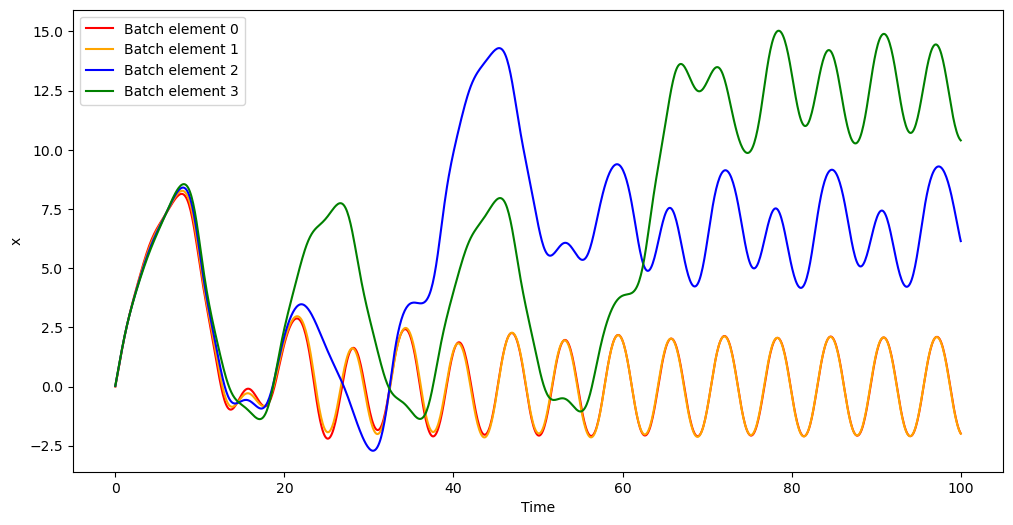

In [10]:
# Reset time and state.
ta.set_time([0., 0., 0., 0.])
ta.state[:] = [[0.00, 0.01, 0.02, 0.03], [1.85, 1.86, 1.87, 1.88]]

# Create identical time grids.
import numpy as np
t_grid = np.repeat(np.linspace(0, 100, 1000), batch_size).reshape(1000, -1)

# Propagate over the time grids.
_, out = ta.propagate_grid(t_grid)

# Plot the time evolution of x.
from matplotlib.pylab import plt
fig = plt.figure(figsize = (12, 6))
plt.plot(t_grid[:, 0], out[:, 0, 0], label="Batch element 0", color='red')
plt.plot(t_grid[:, 1], out[:, 0, 1], label="Batch element 1", color='orange')
plt.plot(t_grid[:, 2], out[:, 0, 2], label="Batch element 2", color='blue')
plt.plot(t_grid[:, 3], out[:, 0, 3], label="Batch element 3", color='green')
plt.xlabel("Time")
plt.ylabel("x")
plt.legend();

In this example, we chose to propagate all batch elements using the same time grid, but we could have chosen to propagate different batch elements using different time grids.

The plot for the time evolution of $x$ shows how this dynamical system is sensitive to the initial conditions: whereas batch elements 0 and 1 evolve together towards the same periodic behaviour, batch elements 2 and 3 exhibit a qualitatively-different evolution.

We can print to screen ``propagate_res`` to find out how many timesteps each batch required and what were the sizes of the smallest and largest integration timesteps:

In [11]:
ta.propagate_res

[(<taylor_outcome.time_limit: -4294967299>,
  0.17712187414656672,
  0.42922678763927685,
  445),
 (<taylor_outcome.time_limit: -4294967299>,
  0.17864079697444862,
  0.43116413615127175,
  442),
 (<taylor_outcome.time_limit: -4294967299>,
  0.17166730017463622,
  0.48845285378323666,
  370),
 (<taylor_outcome.time_limit: -4294967299>,
  0.18536036318220903,
  0.46761939336987596,
  364)]

An important difference with respect to scalar mode is that the vector returned
by ``propagate_grid()`` in batch mode always contains values for *all* grid points,
event if the integration is terminated early (e.g., due to errors or to terminal
events triggering). In scalar mode, by contrast, in case of early termination
``propagate_grid()`` returns only the output values for the grid points that
could be computed before the early exit. In batch mode, the values for the grid
points that could not be reached due to early exit are filled with NaNs.

## Dense output

The batch integrator also supports [dense output](<./Dense output.ipynb>). Like for ``taylor_adaptive``,
enabling dense output is a two-step process. First we invoke one of the ``step()`` (or ``propagate_*()``) functions
with the optional flag ``write_tc`` set to ``True``. This will write the Taylor coefficients that were
used to propagate the last timestep into an internal vector:

In [12]:
# Reset time and state.
ta.set_time([0., 0., 0., 0.])
ta.state[:] = [[0.00, 0.01, 0.02, 0.03], [1.85, 1.86, 1.87, 1.88]]

# Propagate for a timestep, making
# sure the Taylor coefficients are recorded.
ta.step(write_tc = True)

# Print the array of Taylor coefficients.
ta.tc

array([[[ 0.00000000e+00,  1.00000000e-02,  2.00000000e-02,
          3.00000000e-02],
        [ 1.85000000e+00,  1.86000000e+00,  1.87000000e+00,
          1.88000000e+00],
        [ 4.07500000e-01,  3.92700083e-01,  3.77800667e-01,
          3.62802250e-01],
        [-3.21916667e-01, -3.24383503e-01, -3.26716362e-01,
         -3.28913775e-01],
        [-6.75770833e-02, -6.40280151e-02, -6.04283792e-02,
         -5.67795484e-02],
        [ 7.02109167e-02,  7.16133044e-02,  7.29717323e-02,
          7.42848569e-02],
        [ 2.57157556e-02,  2.45104498e-02,  2.32584223e-02,
          2.19601549e-02],
        [-1.57976537e-02, -1.66107095e-02, -1.74021378e-02,
         -1.81703716e-02],
        [-1.00353587e-02, -9.68202996e-03, -9.29913499e-03,
         -8.88692852e-03],
        [ 3.42185259e-03,  3.80286542e-03,  4.17724062e-03,
          4.54381437e-03],
        [ 3.71632697e-03,  3.63550405e-03,  3.53850922e-03,
          3.42533322e-03],
        [-5.74043833e-04, -7.39223443e-04, 

Quite a mouthful! Let's print to screen the order-0 Taylor coefficients
of $x$ and $v$ for all batch elements:

In [13]:
ta.tc[:, 0, :]

array([[0.  , 0.01, 0.02, 0.03],
       [1.85, 1.86, 1.87, 1.88]])

Indeed, as expected the order-0 Taylor coefficients correspond to the initial conditions.

After computing the Taylor coefficients, we can ask for the dense output
at different time coordinates:

In [14]:
# Compute the dense output at different time coordinates.
ta.update_d_output([0.01, 0.02, 0.03, 0.04])

array([[0.01854043, 0.04735447, 0.07643115, 0.1057593 ],
       [1.85805316, 1.87531675, 1.89177968, 1.90743182]])

## Continuous output

Starting with heyoka.py 0.16, the batch integrator also supports [continuous output](<./Dense output.ipynb>). The batch mode continuous output API is similar to the scalar mode API. Specifically, if the ``propagate_for/until()`` methods of a batch integrator are invoked with the ``c_output = True`` keyword option, then they will return a function object which can be used to compute the result of the numerical integration at any point of the integration interval:

In [15]:
# Reset time and state.
ta.set_time([0., 0., 0., 0.])
ta.state[:] = [[0.00, 0.01, 0.02, 0.03], [1.85, 1.86, 1.87, 1.88]]

# Propagate for a few time units, and request continuous output.
c_out, _ = ta.propagate_until([10., 10.1, 10.2, 10.3], c_output=True)

Like in the scalar case, the call operator of ``c_out`` in batch mode accepts two types of input:

* a 1D array of $n$ times, with each element representing the time at which the continuous output should be computed for the corresponding batch index, or
* a 2D array of with $n$ columns, with each row representing a batch of time coordinates.

Let us see a couple of simple examples:

In [16]:
# Compute the continuous output for
# a single batch of times.
c_out([.01, .02, .03, .04])

array([[0.01854043, 0.04735447, 0.07643115, 0.1057593 ],
       [1.85805316, 1.87531675, 1.89177968, 1.90743182]])

In [17]:
# Compute the continuous output for
# three batches of times.
c_arr = c_out([[.01, .02, .03, .04],
               [1.01, 1.02, 1.03, 1.04],
               [2.01, 2.02, 2.03, 2.04]])

The shape of ``c_arr`` is $\left( 3, 2, 4\right)$:

* 3 batches of times,
* 2 state variables,
* 4 batch elements.

For instance, the value of the $v$ coordinate at batch index 2 for the first batch of times is:

In [18]:
c_arr[0,1,2]

1.8917796783928316

## Event detection

Starting with heyoka.py 0.16, the batch integrator also supports [event detection](<./Event detection.ipynb>). The batch mode event detection API is similar to the scalar mode API, with the following differences:

* the event classes in batch mode are called ``nt_event_batch`` and ``t_event_batch``
  (for non-terminal and terminal events respectively), rather than ``nt_event`` and ``t_event``;
* with respect to scalar mode, the callback signatures in batch mode feature an extra trailing argument
  of type ``int`` that indicates in which element of the batch the event was detected.
  
In order to illustrate how event detection works in batch mode, we will be again integrating
the [forced damped pendulum](<./Non-autonomous systems.ipynb>). During the integration, we will
use a non-terminal event to detect when the bob reaches a local amplitude maximum. In other
words, the event equation is

$$
v = 0,
$$

subject to the constraint that the direction of the event must be *negative*.

Let us begin with the definition of the callback for the event:

In [19]:
# List of lists in which we will store
# the times at which the bob is at a local
# amplitude maximum for each batch element.
max_list = list([] for _ in range(batch_size))

def cb(ta, t, d_sgn, bidx):
    # Append the local maximum time
    # for the current batch index.
    max_list[bidx].append(t)

Next, we proceed to the definition of the integrator object:

In [20]:
# Create the integrator object.
ta = hy.taylor_adaptive_batch(
                        # The dynamics.
                        eqns,
                        # Initial conditions for x and v.
                        state = [[0.00, 0.01, 0.02, 0.03], [1.85, 1.86, 1.87, 1.88]],
                        # Values for alpha.
                        pars = [[0.10, 0.11, 0.12, 0.13]],
                        # Non-terminal events.
                        nt_events = [hy.nt_event_batch(v, cb, direction=hy.event_direction.negative)]
                        )

We can now propagate over a time grid...

In [21]:
# Create identical time grids.
t_grid = np.repeat(np.linspace(0, 100, 1000), batch_size).reshape(1000, -1)

# Propagate over the time grids.
_, out = ta.propagate_grid(t_grid)

... and visualise the result:

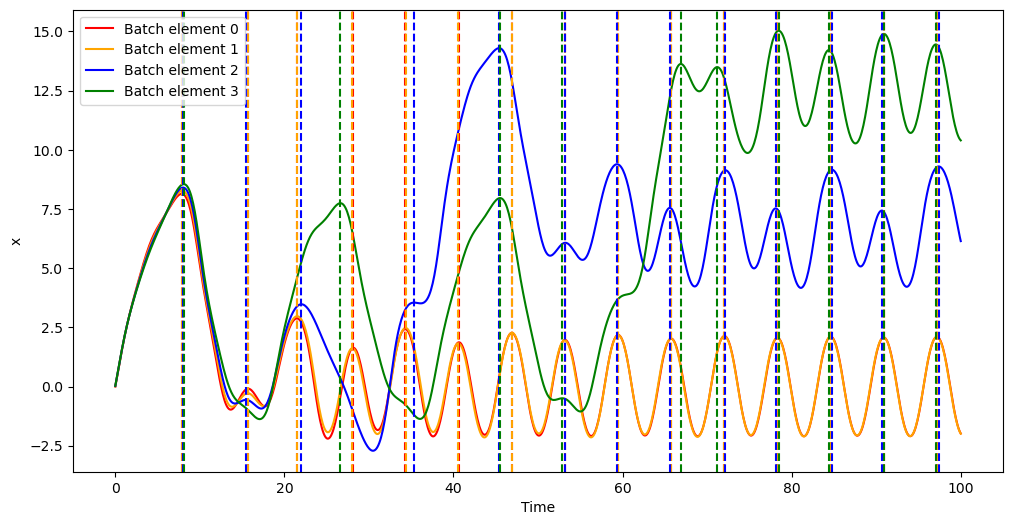

In [22]:
fig = plt.figure(figsize = (12, 6))

plt.plot(t_grid[:, 0], out[:, 0, 0], label="Batch element 0", color='red')
plt.plot(t_grid[:, 1], out[:, 0, 1], label="Batch element 1", color='orange')
plt.plot(t_grid[:, 2], out[:, 0, 2], label="Batch element 2", color='blue')
plt.plot(t_grid[:, 3], out[:, 0, 3], label="Batch element 3", color='green')

ymin,ymax = plt.ylim()

plt.vlines(max_list[0], ymin, ymax, color='red', linestyle='dashed')
plt.vlines(max_list[1], ymin, ymax, color='orange', linestyle='dashed')
plt.vlines(max_list[2], ymin, ymax, color='blue', linestyle='dashed')
plt.vlines(max_list[3], ymin, ymax, color='green', linestyle='dashed')

plt.ylim((ymin, ymax))

plt.xlabel("Time")
plt.ylabel("x")
plt.legend();

Here we marked with vertical dashed lines the times of the local maxima, which, as we can see, were all correctly detected.

As an another example, we will be re-formulating the [wavy ramp tutorial](<./The wavy ramp.ipynb>) in batch mode. The code adaptations for batch mode are small and mostly involve the callbacks and the auxiliary structures to store the coordinates of the bouncing points. The batch elements will feature slightly different initial drop heights for the bouncing ball.

Let us formulate and integrate the problem:

In [23]:
# The dynamical variables.
x, y, vx, vy = hy.make_vars("x", "y", "vx", "vy")

# The dynamics.
eqns = [(x, vx),
        (y, vy),
        (vx, hy.expression(0.)),
        # Downwards constant acceleration.
        (vy, hy.expression(-9.8))]

# Event equation for the ramp.
eq_w_curve = y - (1. - x + 0.05 * hy.cos(11 * np.pi * x))

# Event equation for the ground.
eq_bottom = y

# The coefficient of restitution.
CR = .8

# Global variables to track
# the time of the last collision
# and the collision points.
last_t = [0.] * batch_size
bounce_points = list([] for _ in range(batch_size))

# Callback for bouncing against the curve.
def cb_w_curve(ta, mr, d_sgn, bidx):
    global last_t

    # If the last collision happened
    # too recently, return False to
    # stop the simulation.
    if ta.time[bidx] - last_t[bidx] < 1e-6:
        return False

    # Update last_t.
    last_t[bidx] = ta.time[bidx]

    # Update bounce_points.
    x, y = ta.state[0:2, bidx]
    bounce_points[bidx].append((x, y))
    
    # Compute the normal unit vector
    # using the gradient of the event
    # equation.
    grad = np.array([1+0.05*11*np.pi*np.sin(11*np.pi*x), 1])
    grad_uvec = grad / np.linalg.norm(grad)
    
    # Compute the component of the velocity
    # across the normal vector.
    xy_vel = ta.state[2:4, bidx]
    vproj = np.dot(xy_vel, grad_uvec)
    
    # Flip it and rescale it according
    # to the coefficient of restitution.
    Dv = -vproj*grad_uvec
    xy_vel += (1. + CR) * Dv

    return True

# Callback for bouncing off the ground.
def cb_bottom(ta, mr, d_sgn, bidx):
    global last_t
    
    # If the last collision happened
    # too recently, return False to
    # stop the simulation.
    if ta.time[bidx] - last_t[bidx] < 1e-6:
        return False

    # Update last_t.
    last_t[bidx] = ta.time[bidx]

    # Update bounce_points.
    x, y = ta.state[0:2, bidx]
    bounce_points.append((x, y))
    
    # Flip the y component of the velocity,
    # and rescale it according
    # to the coefficient of restitution.
    ta.state[3, bidx] = -CR*ta.state[3, bidx]
    
    return True

# Create the batch integrator.
ta = hy.taylor_adaptive_batch(eqns,
                              [[0]*batch_size,
                               # Set slightly different drop heights
                               # for each batch element.
                               list(1.2 - i/50 for i in range(batch_size)),
                               [0]*batch_size,
                               [0]*batch_size],
                              t_events = [hy.t_event_batch(eq_w_curve, callback = cb_w_curve, direction = hy.event_direction.negative),
                                          hy.t_event_batch(eq_bottom, callback = cb_bottom, direction = hy.event_direction.negative)])

# Define the time grids and integrate.
t_grid = np.repeat(np.linspace(0, 10, 10000), batch_size).reshape(10000, -1)
_, res = ta.propagate_grid(t_grid)

Let us now take a look at the result:

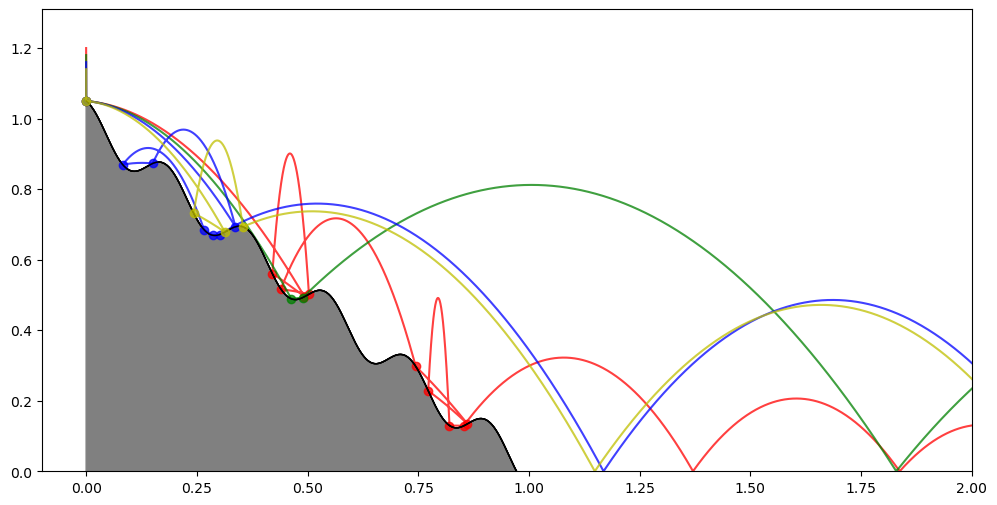

In [24]:
fig = plt.figure(figsize = (12, 6))

colors=['r', 'g', 'b', 'y']

for bidx in range(batch_size):
    plt.plot(res[:,0,bidx],res[:,1,bidx], color=colors[bidx], alpha=.75)
    x_grid = np.linspace(0, 1., 1000)
    plt.plot(x_grid, (1 - x_grid + 0.05 * np.cos(11 * np.pi * x_grid)), 'k-', linewidth=1)
    b_points = np.array(bounce_points[bidx])
    plt.plot(b_points[:, 0], b_points[:, 1], 'o', color=colors[bidx], alpha=.75)
plt.fill_between(x_grid, -1., (1 - x_grid + 0.05 * np.cos(11 * np.pi * x_grid)), color='gray')
plt.ylim(0, None)
plt.xlim(-.1, 2);

We can see how setting slightly different drop heights for each batch element soon leads to qualitatively-different trajectories.

## Ensemble propagations


[Ensemble propagations](<./ensemble_mode.ipynb>) are also available in batch mode. The API is identical
to scalar mode ensemble propagations. Specifically, the following functions are available:

* ``ensemble_propagate_until_batch()``, for batch ensemble propagations
  up to a specified epoch,
* ``ensemble_propagate_for_batch()``, for batch ensemble propagations
  for a time interval,
* ``ensemble_propagate_grid_batch()``, for batch ensemble propagations
  over a time grid.

Like their scalar counterparts, the batch ensemble propagation functions accept in input:

* the template batch integrator ``ta``,
* the final epoch, time interval or time grid to be used in the propagations,
* the number of iterations ``n_iter`` in the ensemble,
* the generator ``gen``.

Note however that, whereas the ``propagate_*()`` member functions of the batch integrator
allow to use distinct epochs, time intervals or time grids for each batch element, in batch ensemble
propagations a single epoch, time interval or time grid is used for *all* batch elements in *all* iterations
of the ensemble. In particular, while the ``propagate_grid()`` member function of the batch integrator
expects a 2D array in input (i.e., an array of time batches), the ``ensemble_propagate_grid_batch()``
function expects in input a 1D array (i.e., an array of scalars, just like the scalar
``propagate_grid()`` member function).

Let us a show a simple example, based again on the [forced damped pendulum](<./Non-autonomous systems.ipynb>).
We begin with the definition of the dynamical equations and of the template integrator:

In [25]:
# Equations of motion.
eqns = [(x, v),
        (v, hy.cos(hy.time) - hy.par[0]*v - hy.sin(x))]

# Create the template integrator.
ta = hy.taylor_adaptive_batch(
                        # The dynamics.
                        eqns,
                        # Zero out the initial conditions
                        # and the values for the runtime
                        # parameters
                        state = np.zeros((2, 4)),
                        pars = np.zeros((1, 4)))

Next, we randomly generate 10 sets of batches of values which we will use to perturb the initial conditions and the runtime parameters:

In [26]:
# Randomly generate perturbations on the initial conditions
# and on the values of the friction constant.
delta_ics = np.random.uniform(-1e-1, 1e-1, (10, 2, 4))
delta_params = np.random.uniform(0., 1e-1, (10, 1, 4))

We can now proceed with the definition of the generator, which will assign to each batch integrator randomly-generated initial conditions and runtime parameter values based on the ``delta_ics`` and ``delta_params`` arrays we just created:

In [27]:
def gen(ta_copy, idx):
    ta_copy.set_time(0.)
    
    ta_copy.state[:] = np.repeat([0., 1.85], 4).reshape((2,4)) + delta_ics[idx]
    ta_copy.pars[:] = np.repeat([0.1], 4).reshape((1,4)) + delta_params[idx]
    
    return ta_copy

We are now ready to run the ensemble propagation:

In [28]:
ret = hy.ensemble_propagate_until_batch(ta, 100., 10, gen, c_output=True)

Let us summarise in a single plot the time evolution of the $x$ coordinate for *all* batch elements in *all* the ensemble iterations:

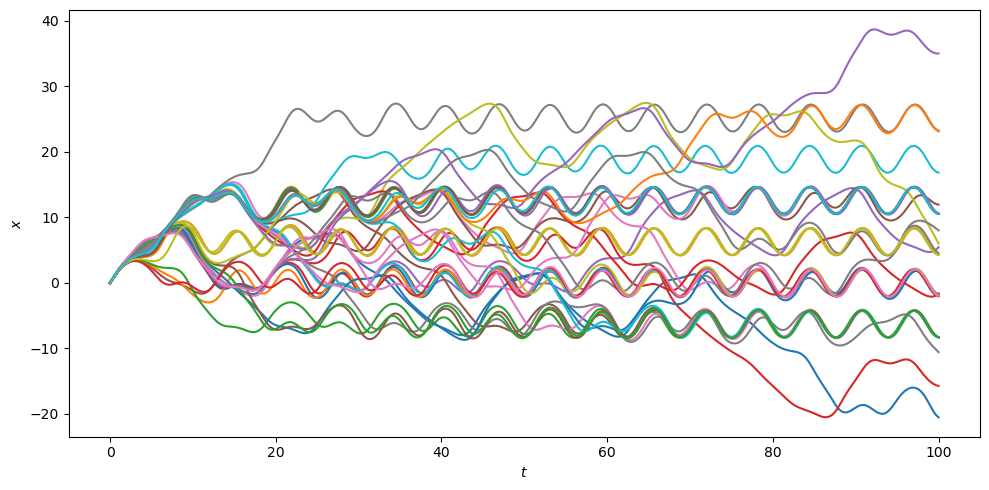

In [29]:
from matplotlib.pylab import plt

fig = plt.figure(figsize=(10, 5))

# Create a range of time batches.
t_rng = np.linspace(0, 100., 500).repeat(4).reshape(-1, 4)

for tup in ret:
    # Fetch the continuous output function object.
    c_out = tup[1]

    plt.plot(t_rng, c_out(t_rng)[:,0])

plt.xlabel("$t$")
plt.ylabel("$x$")
plt.tight_layout();